In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets, model_selection
import numpy as np
import copy
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))  # увеличение ширины ячейки блокнота
import warnings
warnings.filterwarnings("ignore",category=UserWarning)  # убираем ненужные предупреждение matplotlib

In [2]:
random.seed(42)
def get_bootstrap(data, labels, N):
    '''
    Создание из данных нескольких N наборов, в каждом из которых недостает 37% объектов
    '''
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
    return bootstrap

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
    return subsample

class Node:
    '''
    Класс узла
    '''
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

class Leaf:
    '''
    класс терминального узла (листа)
    '''
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

def gini(labels):
    '''
    Расчет критерия Джини
    '''
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2   
    return impurity

def quality(left_labels, right_labels, current_gini):
    '''
    Расчет качества
    '''
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

def split(data, labels, index, t):
    '''
    Разбиение датасета в узле
    '''
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    return true_data, false_data, true_labels, false_labels

def find_best_split(data, labels):
    '''
    Нахождение наилучшего разбиения
    '''
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            current_quality = quality(true_labels, false_labels, current_gini)
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
    return best_quality, best_t, best_index

def build_tree(data, labels):
    '''
    Построение дерева с помощью рекурсивной функции
    '''
    quality, t, index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

def random_forest(data, labels, n_trees):
    '''
    Формирование случайного леса
    '''
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest

def classify_object(obj, node):
    '''
    Функция классификации отдельного объекта
    '''
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)    

def predict(data, tree):
    '''
    функция формирования предсказания по выборке на одном дереве
    '''
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

def tree_vote(forest, data):
    '''
    предсказание голосованием деревьев
    '''
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    return voted_predictions

def accuracy_metric(actual, predicted):
    '''
    Функция подсчета точности как доли правильных ответов
    '''
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# 1
- Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками
- обучить случайный лес из 1, 3, 10 и 50 деревьев
- визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote)
- Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками

In [3]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

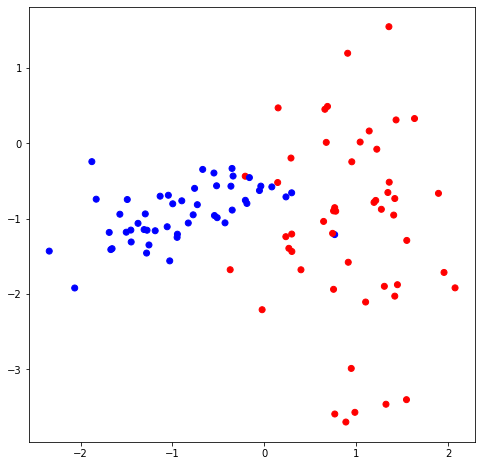

In [4]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

2. Обучить случайный лес из 1, 3, 10 и 50 деревьев

In [5]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [6]:
def create_forests(n_trees_list: list, 
                   train_data=train_data,
                   train_labels=train_labels,
                   test_data=test_data,
                   test_labels=test_labels):
    '''
    Обучение нескольких лесов
    '''
    forests = {}
    forest = {}
    for n_trees in n_trees_list:
        forest['forest'] = random_forest(train_data, train_labels, n_trees)
        # Получим ответы для обучающей выборки 
        forest['train_answers'] = tree_vote(forest['forest'], train_data)
        # И получим ответы для тестовой выборки
        forest['test_answers'] = tree_vote(forest['forest'], test_data)
        # Точность на обучающей выборке
        forest['train_accuracy'] = accuracy_metric(train_labels, forest['train_answers'])
        print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {forest["train_accuracy"]:.3f}')
        # Точность на тестовой выборке
        forest['test_accuracy'] = accuracy_metric(test_labels, forest['test_answers'])
        print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {forest["test_accuracy"]:.3f}')
        forests[n_trees] = copy.deepcopy(forest)
    return forests

In [7]:
forests = create_forests([1, 3, 10, 50])

Точность случайного леса из 1 деревьев на обучающей выборке: 97.143
Точность случайного леса из 1 деревьев на тестовой выборке: 80.000
Точность случайного леса из 3 деревьев на обучающей выборке: 97.143
Точность случайного леса из 3 деревьев на тестовой выборке: 80.000
Точность случайного леса из 10 деревьев на обучающей выборке: 100.000
Точность случайного леса из 10 деревьев на тестовой выборке: 86.667
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 86.667


3. Визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote)

In [8]:
def visualize_forest(my_tree,
                     train_accuracy,
                     test_accuracy,
                     train_data=train_data, 
                     test_data=test_data, 
                     train_labels=train_labels,
                     test_labels=test_labels):
    '''
    Визуализируем дерево на графике
    '''
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    plt.figure(figsize = (16, 7))
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
#     mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    mesh_predictions = np.array(tree_vote(my_tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

Визуализация случайного леса из 1 дерев(а)/(ьев):


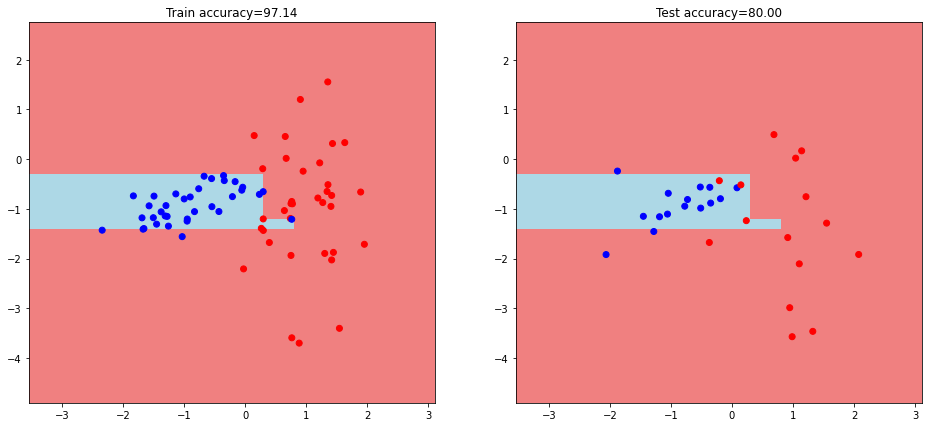

---------------------------------------------------------------------------------------------------------------------------------------
Визуализация случайного леса из 3 дерев(а)/(ьев):


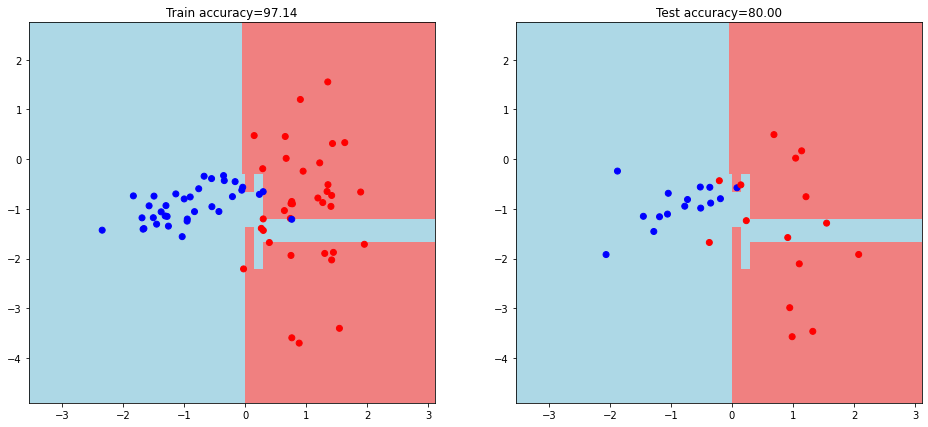

---------------------------------------------------------------------------------------------------------------------------------------
Визуализация случайного леса из 10 дерев(а)/(ьев):


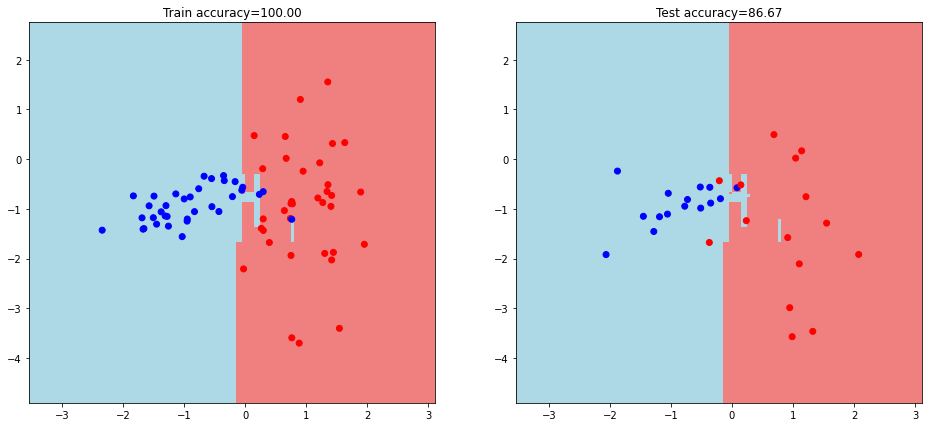

---------------------------------------------------------------------------------------------------------------------------------------
Визуализация случайного леса из 50 дерев(а)/(ьев):


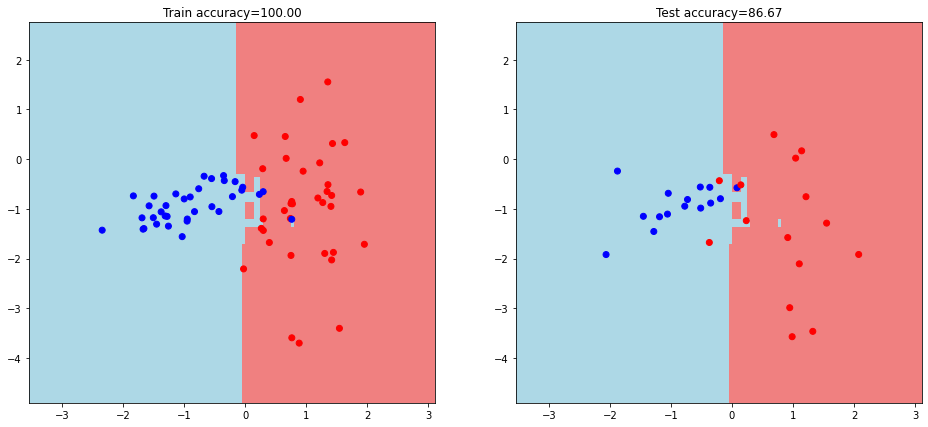

---------------------------------------------------------------------------------------------------------------------------------------


In [9]:
for n_trees in forests.keys():
    forest = forests[n_trees]['forest']
    train_accuracy = forests[n_trees]['train_accuracy']
    test_accuracy = forests[n_trees]['test_accuracy']
    print(f'Визуализация случайного леса из {n_trees} дерев(а)/(ьев):')
    visualize_forest(forest, train_accuracy, test_accuracy)
    print('---------------------------------------------------------------------------------------------------------------------------------------')

4. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

In [10]:
# Лес из 1 дерева выглядит недобученным, гиперплоскость выглядет слишком простой
# Леса с бОльшим количеством деревьев выглядят переобученными, гиперплоскость выглядет сложной, что скорее всего связано с малой выборкой
# Оптимальным, с точки зрения предела точности и вида гиперплоскости выглядит лес из 10 деревьев

***
# 2
Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [11]:
random.seed(42)
def get_bootstrap_oob(data, labels, N):
    '''
    Создание из данных нескольких N наборов, в каждом из которых недостает 37% объектов
    Возвращает кортеж с бутстрапом и out-of-bag, в каждом: [data и label]
    '''
    n_samples = data.shape[0]
    bootstrap = []
    out_of_bag = []
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        # Получение Out-of-Bag данных
        for b_ in b_data:
            for ind, row in enumerate(data):
                if np.all(b_ != row):
                    oob_data = row  # data, которые не попали в бутстрап
                    oob_labels = labels[ind]  # label, которые соответствуют data out-of-bag
                    out_of_bag.append((oob_data, oob_labels))
        bootstrap.append((b_data, b_labels))
    return bootstrap, out_of_bag

def random_forest_oob(data, labels, n_trees):
    '''
    Формирование случайного леса, с набором out-of-bag данных
    '''
    forest = []
    bootstrap_oob = get_bootstrap_oob(data, labels, n_trees)
    bootstrap = bootstrap_oob[0]
    oob = bootstrap_oob[1]
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest, oob

def tree_vote_oob(forest, data_oob):
    '''
    предсказание голосованием деревьев с прикреплением out-of-bag данных
    '''
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    return voted_predictions

def create_forests_oob(n_trees_list: list, 
                       train_data=train_data,
                       train_labels=train_labels):
    '''
    Обучение нескольких лесов с проверкой на out-of-bag данных
    '''
    forests = {}
    forest = {}
    oob_res = [] # для последующей визуализации
    for n_trees in n_trees_list:
        f = random_forest_oob(train_data, train_labels, n_trees)
        forest['forest'] = f[0]
        oob = f[1]
        oob_data = list(map(lambda x: x[0], oob))
        forest['oob_data'] = oob_data
        oob_labels = list(map(lambda x: x[1], oob))
        forest['oob_labels'] = oob_labels
        # Получим ответы для обучающей выборки 
        forest['train_answers'] = tree_vote(forest['forest'], train_data)
        # И получим ответы для выборки out-of-bag
        forest['test_answers'] = tree_vote(forest['forest'], oob_data)
        # Точность на обучающей выборке
        forest['train_accuracy'] = accuracy_metric(train_labels, forest['train_answers'])
        print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {forest["train_accuracy"]:.3f}')
        # Точность на выборке out-of-bag
        forest['test_accuracy'] = accuracy_metric(oob_labels, forest['test_answers'])
        print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {forest["test_accuracy"]:.3f}')
        forests[n_trees] = copy.deepcopy(forest)
    return forests

def visualize_forest_oob(my_tree,
                         train_accuracy,
                         test_accuracy,
                         train_data=train_data, 
                         train_labels=train_labels):
    '''
    Визуализируем дерево на графике
    '''
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    
    test_data = np.stack(my_tree['oob_data'])
    test_labels = np.stack(my_tree['oob_labels'])
    my_tree = my_tree['forest']
    plt.figure(figsize = (16, 7))
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
#     mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    mesh_predictions = np.array(tree_vote(my_tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

In [12]:
forests = create_forests_oob([1, 3, 10, 50])

Точность случайного леса из 1 деревьев на обучающей выборке: 97.143
Точность случайного леса из 1 деревьев на тестовой выборке: 97.101
Точность случайного леса из 3 деревьев на обучающей выборке: 97.143
Точность случайного леса из 3 деревьев на тестовой выборке: 97.108
Точность случайного леса из 10 деревьев на обучающей выборке: 100.000
Точность случайного леса из 10 деревьев на тестовой выборке: 100.000
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 100.000


Визуализация случайного леса из 1 дерев(а)/(ьев):


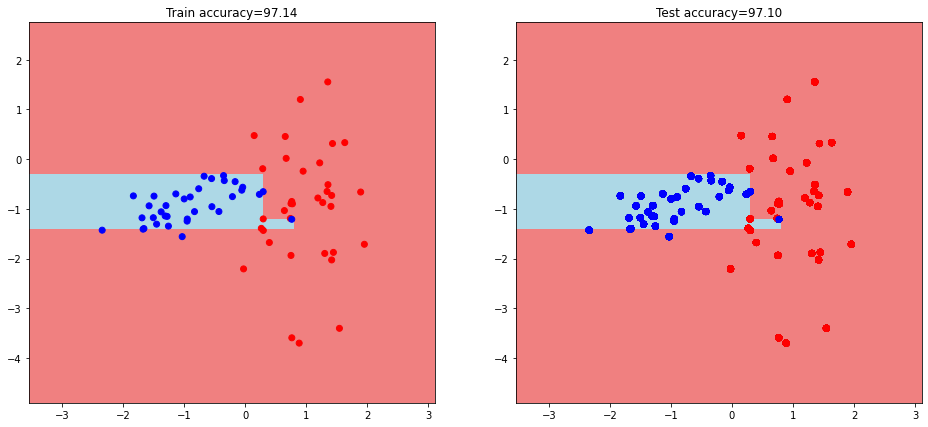

---------------------------------------------------------------------------------------------------------------------------------------
Визуализация случайного леса из 3 дерев(а)/(ьев):


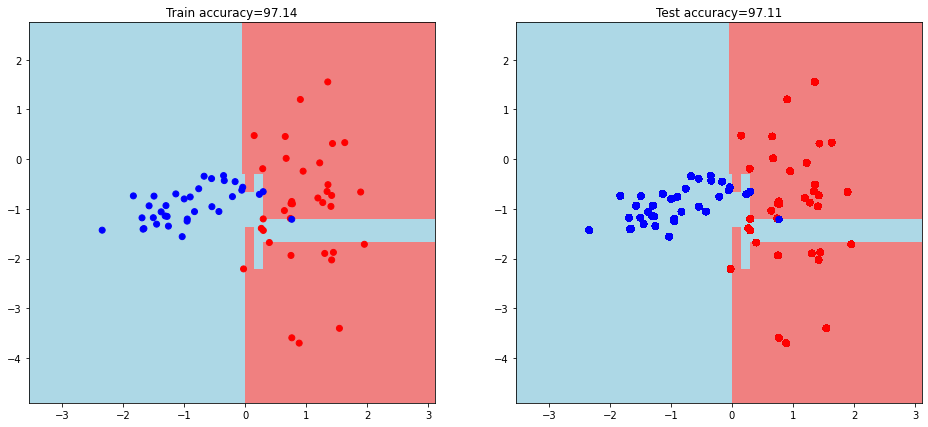

---------------------------------------------------------------------------------------------------------------------------------------
Визуализация случайного леса из 10 дерев(а)/(ьев):


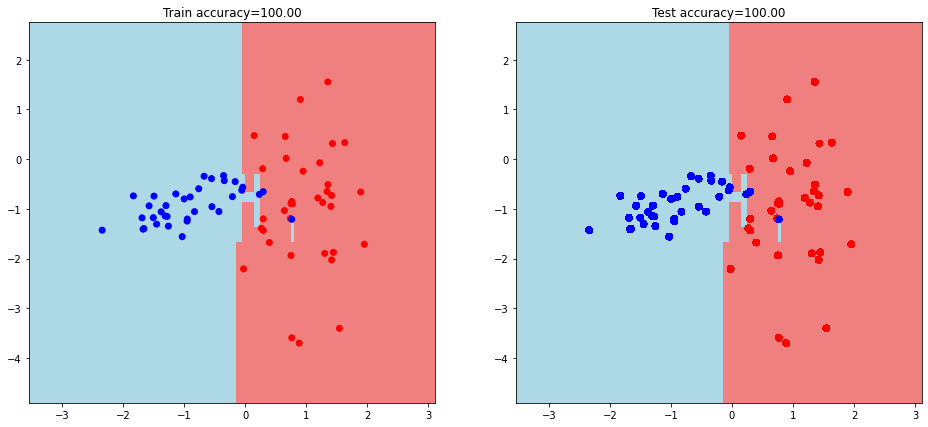

---------------------------------------------------------------------------------------------------------------------------------------
Визуализация случайного леса из 50 дерев(а)/(ьев):


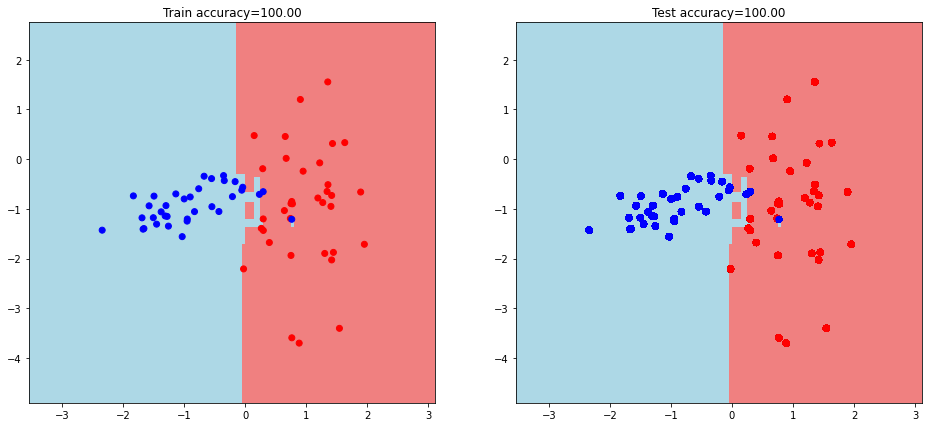

---------------------------------------------------------------------------------------------------------------------------------------


In [13]:
for n_trees in forests.keys():
    forest = forests[n_trees]
    train_accuracy = forests[n_trees]['train_accuracy']
    test_accuracy = forests[n_trees]['test_accuracy']
    print(f'Визуализация случайного леса из {n_trees} дерев(а)/(ьев):')
    visualize_forest_oob(forest, train_accuracy, test_accuracy)
    print('---------------------------------------------------------------------------------------------------------------------------------------')